# Explainable AI, Homework 5, Aleksandra Mysiak
Permutation-based Variable Importance analysis for the [heart disease dataset](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset).

## PVI for the previously selected model
The main model analysed here is the same one that was used in previous notebooks. It's an XGBoostClassifier, with hyperparameters `n_estimators=200` and `max_depth=4`.

We can see a tie between the two most important variables -- `thall_2` and `oldpeak`. The two seem to be significantly more important than the other variables, with another noticeable break around `caa_2` and `cp_3`. Surprisingly, other values of the `thall` feature are not in the top 10, indicating the existence of a single, most telling value.

Overall, the absolute values of importances seem to be pretty low, which might indicate that no single value is enough to explain the model's behaviour -- or, more precisely, the changes in loss over all test observations. For a model that features interactions, this is not a surprising result.

![](xgboost_4.png)

## PVI comparison between different models
In this section, we will take a look at PVI results for 4 different models: 3 XGBoost classifiers, with different `max_depth` values, and a single logistic regression model. Below we have a table with accuracy and F1 scores on the test set for the 4 models.


| Model                | Accuracy | F1    |
|----------------------|----------|-------|
| XGBoost, max_depth=2 | 0.787    | 0.817 |
| XGBoost, max_depth=4 | 0.754    | 0.795 |
| XGBoost, max_depth=6 | 0.754    | 0.795 |
| Logistic regression  | 0.852    | 0.866 |

We can see that the XGBoost models seem to overfit, as a higher `max_depth` indicates a higher model flexibility.

Looking at PVI plots, for the XGBoost models, we can see that the top 10 sets do not differ much, with IoU between both pairs ((2, 4) and (4, 6)) of sets of 0.82 (9 elements in common). The ordering of the features changes a bit, with each plot having a different best feature. This is not surprising, as even for models trained with the same hyperparameters, but different seeds, the importances can differ.

Another noticeable thing about the XGBoost plots is that the absolute values of the highest importances go up with the models' flexibility. This feels counterintuitive, as a less flexible model could focus on a smaller set of predictors more, without capturing nuances of multiple features. This intuition turns out to be invalid in this case -- presumably due to the models' ability to include interactions. In this case, we might also interpret this as a sign of overfitting, as the model over-prioritizes certain features.

For logistic regression, the value of importance for the top feature is noticeably higher than for XGBoost models. This is understandable for a simple model with no interactions, since singular features are the only factors responsible for the entire loss drop.

We can see that the set of top 10 features is a bit different, with 8 out of 10 appearing in any of the top 10s for XGBoost models.

Interestingly, the `thall_2` feature (or any other `thall` value) that seems to be very important for all XGBoost models is not included in the top 10 for logistic regression. This might be a sign of it mainly being important in interactions with other features. In general, it could also indicate that the shape of the relation between this variable and the illness risk is non-trivial and cannot be captured by a simple model, but since this is a binary feature, it is not the case here.

![](xgboost_2.png)
![](xgboost_4.png)
![](xgboost_6.png)
![](logistic.png)

## PVI and XGBoost 'gain' importance comparison
The `gain` importance in XGBoost measures improvement of model's accuracy when adding variables. Below, we have two plots of top 10 variables for the same XGBoost model, as scored using two methods:
* PVI, 
* XGBoost `gain`. 

We can see that the values here are of different orders of magnitude, and their absolute values are not comparable, since they measure different changes. We can, however, analyse the results qualitatively.

Both methods point to the same variable as the most important one. There are, however, vast differences between rankings of other variables in the two top tens, with the IoU of the two sets at just 0.43 (6 shared elements). The most contrasting variable seems to be `oldpeak`, which is very close to the best value when using PVI, and at the bottom of the `gain` ranking. This tells us that the two methods of variable importance measurement measure different effects that are not very well correlated, suggesting that the notion of "variable importance" is not universal and well-defined, and depends on chosen methodology.

![](xgboost_4.png)

![](gain.png)

## PVI and SHAP comparison
Below, we have two plots of top 10 most important variables for the same XGBoost model, as measured in two ways:
* Using PVI,
* Averaging absolute values of TreeSHAP for all test set examples.

Once again, the values here measure different effects, so we cannot compare the numbers quantitatively.

Qualitatively, once again, the two methods chose the same feature as the most important one. This seems to suggest that, although the concept of "variable importance" differs between methods, the `thall_2` feature is in fact the most informative for our model.

Other than that, there are once again quite a few differences between the rankings. The IoU of the sets is 0.54. Interestingly, the 7 shared elements are the top 7 of the PVI-ranked variables. There seems to be a bit less discrepancy here than in the previous case. The most extreme difference seems, again, quite noticeable: the `chol` variable, which has the 2nd-highest averaged SHAP contribution, is not featured in the PVI top 10 at all.

Once again, we can draw the conclusion that "variable importance" depends a lot on the method we choose, since different methods
1. Measure changes of different values (e.g. loss, accuracy, prediction value), and
2. Yield differing results.

This suggests a need to specify which method we are using when talking about importance, and also a need to understand the differences between those methods.

![](xgboost_4.png)
![](shap.png)

# Appendix

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import xgboost
import dalex as dx
import plotly.express as px
import shap
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = "../heart.csv"
CATEGORICAL_COLUMNS = ['sex', 'cp', 'fbs', 'restecg', 'caa', 'exng', 'slp', 'thall']
TARGET_COLUMN = 'output'

## Read in and prepare data

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
for column in CATEGORICAL_COLUMNS:
    df[column] = df[column].astype(str)

#### Encode categorical features

In [6]:
df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output', 'sex_1',
       'cp_1', 'cp_2', 'cp_3', 'fbs_1', 'restecg_1', 'restecg_2', 'exng_1',
       'slp_1', 'slp_2', 'caa_1', 'caa_2', 'caa_3', 'caa_4', 'thall_1',
       'thall_2', 'thall_3'],
      dtype='object')

#### Select X and y

In [7]:
X = df.drop(columns = [TARGET_COLUMN])

In [8]:
y = df[TARGET_COLUMN]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 0. For the selected data set, train at least one tree-based ensemble model, e.g. random forest, gbdt, xgboost.


In [10]:
xgboost_model = xgboost.XGBClassifier(
    n_estimators=200, 
    max_depth=4, 
    use_label_encoder=False, 
    eval_metric="logloss",
    importance_type="gain"
)

In [11]:
xgboost_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

## 1. Calculate Permutation-based Variable Importance for the selected model.


In [12]:
def pf_xgboost_classifier_categorical(model, df):
    df.loc[:, df.dtypes == 'object'] =\
        df.select_dtypes(['object'])\
        .apply(lambda x: x.astype('category'))
    return model.predict_proba(df)[:, 1]

explainer = dx.Explainer(xgboost_model, X_test, y_test, predict_function=pf_xgboost_classifier_categorical)

Preparation of a new explainer is initiated

  -> data              : 61 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 61 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function pf_xgboost_classifier_categorical at 0x7ff39634ce50> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 8.96e-05, mean = 0.622, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.997, mean = -0.081, max = 0.938
  -> model_info        : package xgboost

A new explainer has been created!


In [13]:
pvi = explainer.model_parts(random_state=0, label="XGBoost with max_depth = 4")

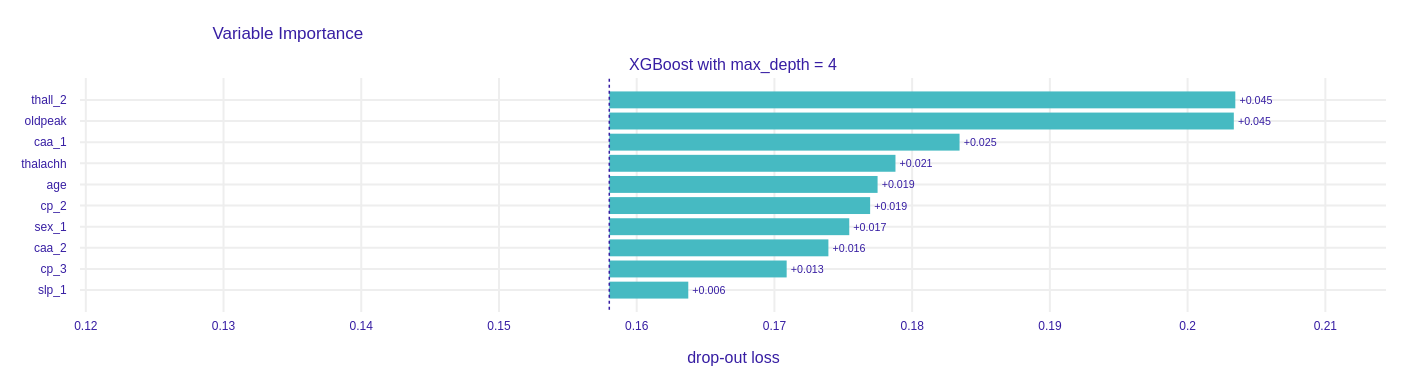

In [59]:
pvi.plot(show=False)

## 2. Train three more candidate models (different variable transformations, different model architectures, hyperparameters) and compare their rankings of important features using PVI. What are the differences? Why?

In [15]:
xgboost_model_2 = xgboost.XGBClassifier(
    n_estimators=200, 
    max_depth=6, 
    use_label_encoder=False, 
    eval_metric="logloss"
)

In [16]:
xgboost_model_2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [17]:
explainer_2 = dx.Explainer(xgboost_model_2, X_test, y_test, predict_function=pf_xgboost_classifier_categorical)

Preparation of a new explainer is initiated

  -> data              : 61 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 61 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function pf_xgboost_classifier_categorical at 0x7ff39634ce50> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000117, mean = 0.632, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.999, mean = -0.091, max = 0.961
  -> model_info        : package xgboost

A new explainer has been created!


In [18]:
pvi_2 = explainer_2.model_parts(random_state=0, label="XGBoost with max_depth = 6")

In [19]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier,0.878788,0.725,0.794521,0.754098,0.841991


In [20]:
explainer_2.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier,0.878788,0.725,0.794521,0.754098,0.841991


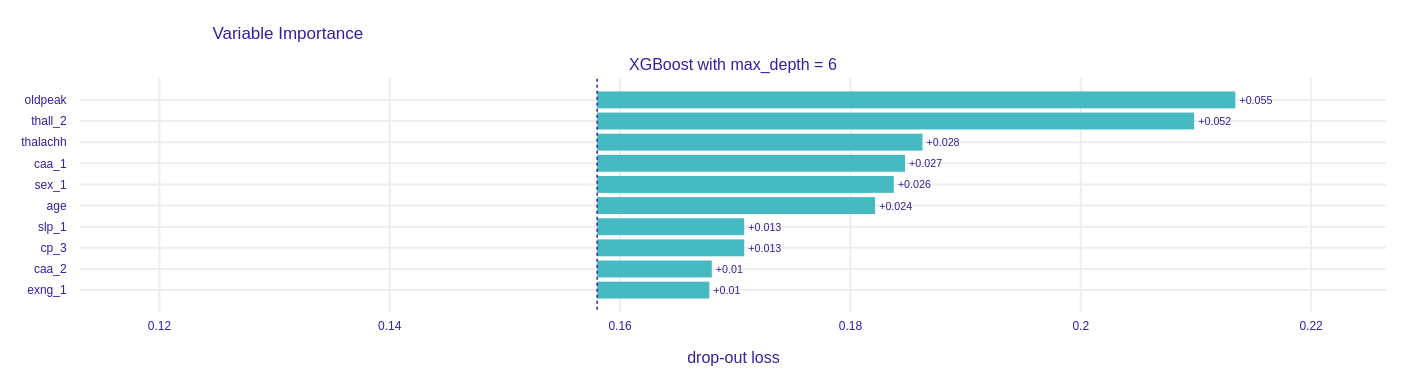

In [58]:
pvi_2.plot(show=False)

In [22]:
xgboost_model_3 = xgboost.XGBClassifier(
    n_estimators=200, 
    max_depth=2, 
    use_label_encoder=False, 
    eval_metric="logloss"
)

In [23]:
xgboost_model_3.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [24]:
explainer_3 = dx.Explainer(xgboost_model_3, X_test, y_test, predict_function=pf_xgboost_classifier_categorical)

Preparation of a new explainer is initiated

  -> data              : 61 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 61 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function pf_xgboost_classifier_categorical at 0x7ff39634ce50> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 5.55e-05, mean = 0.599, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.996, mean = -0.0577, max = 0.964
  -> model_info        : package xgboost

A new explainer has been created!


In [25]:
explainer_3.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier,0.878788,0.763158,0.816901,0.786885,0.829004


In [26]:
pvi_3 = explainer_3.model_parts(random_state=0, label="XGBoost with max_depth = 2")

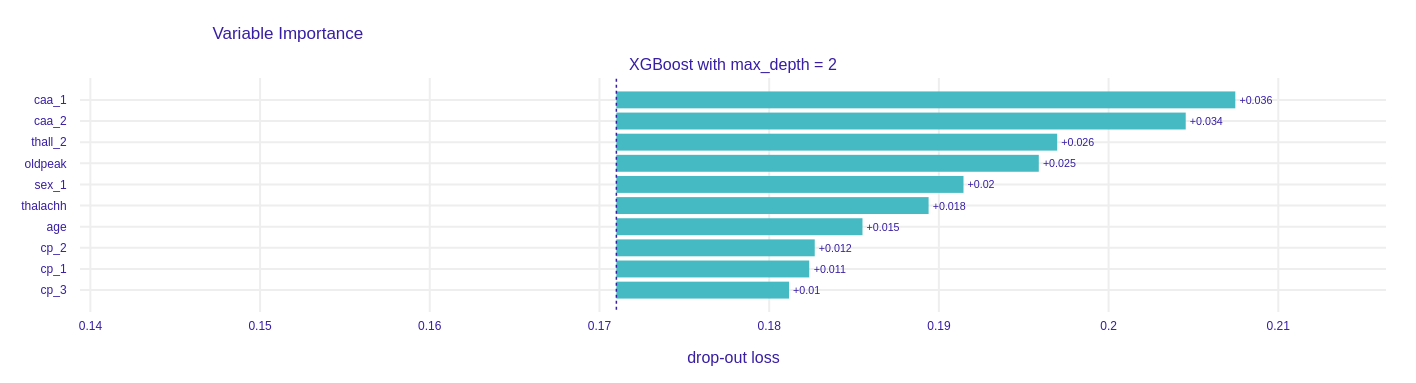

In [57]:
pvi_3.plot()

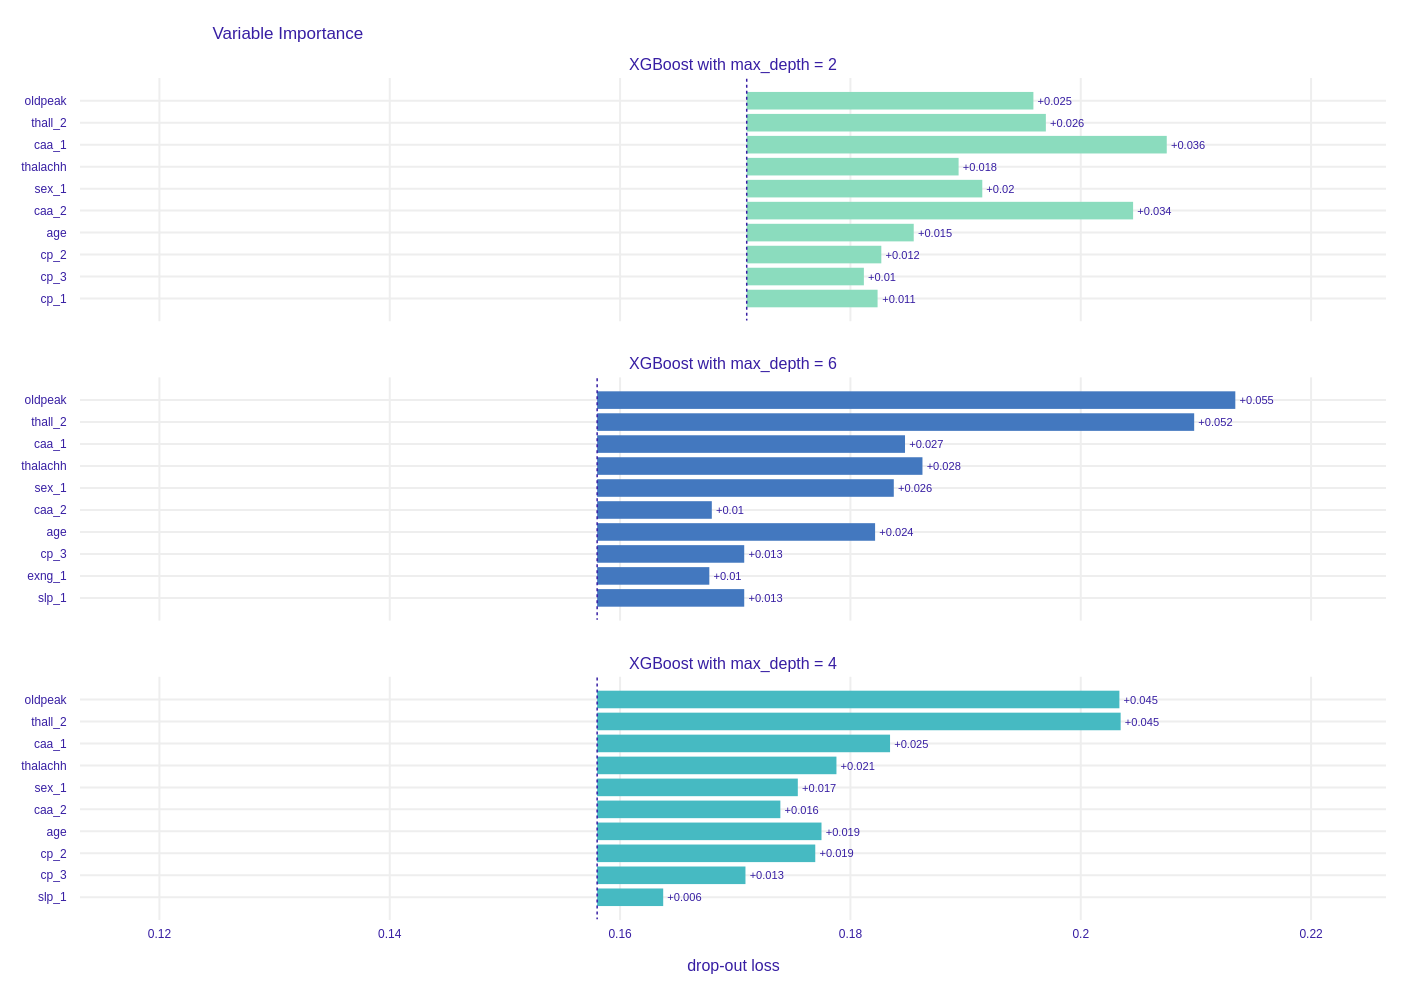

In [56]:
pvi_3.plot([pvi_2, pvi], show=False)

In [28]:
logistic_regression = Pipeline([('scaler', StandardScaler()), ('log', LogisticRegression())])

In [29]:
logistic_regression.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('log', LogisticRegression())])

In [30]:
logistic_explainer = dx.Explainer(logistic_regression, X_test, y_test, label="logistic regression", verbose=False)

In [31]:
logistic_explainer.model_performance()

,recall,precision,f1,accuracy,auc
logistic regression,0.878788,0.852941,0.865672,0.852459,0.91342


In [32]:
pvi_4 = logistic_explainer.model_parts(random_state=0)

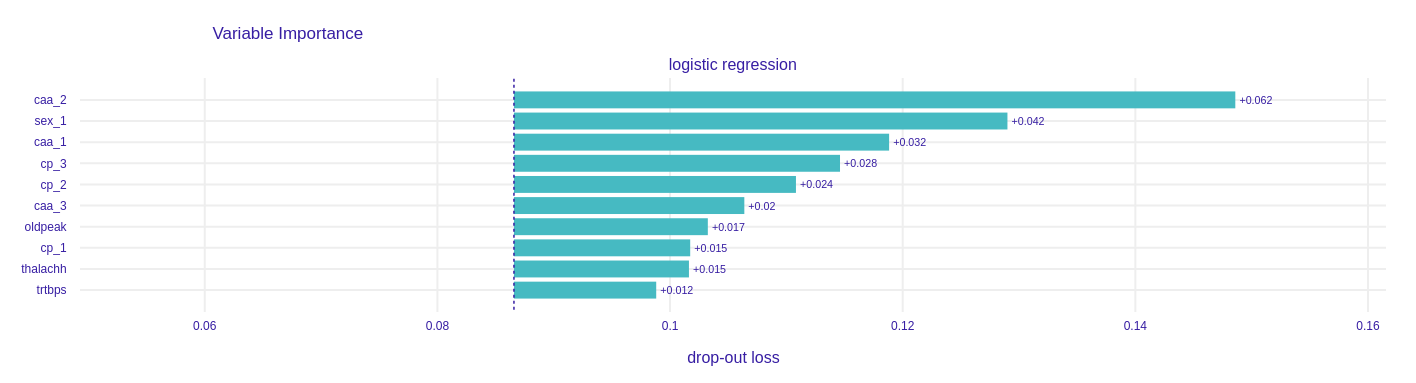

In [64]:
pvi_4.plot()

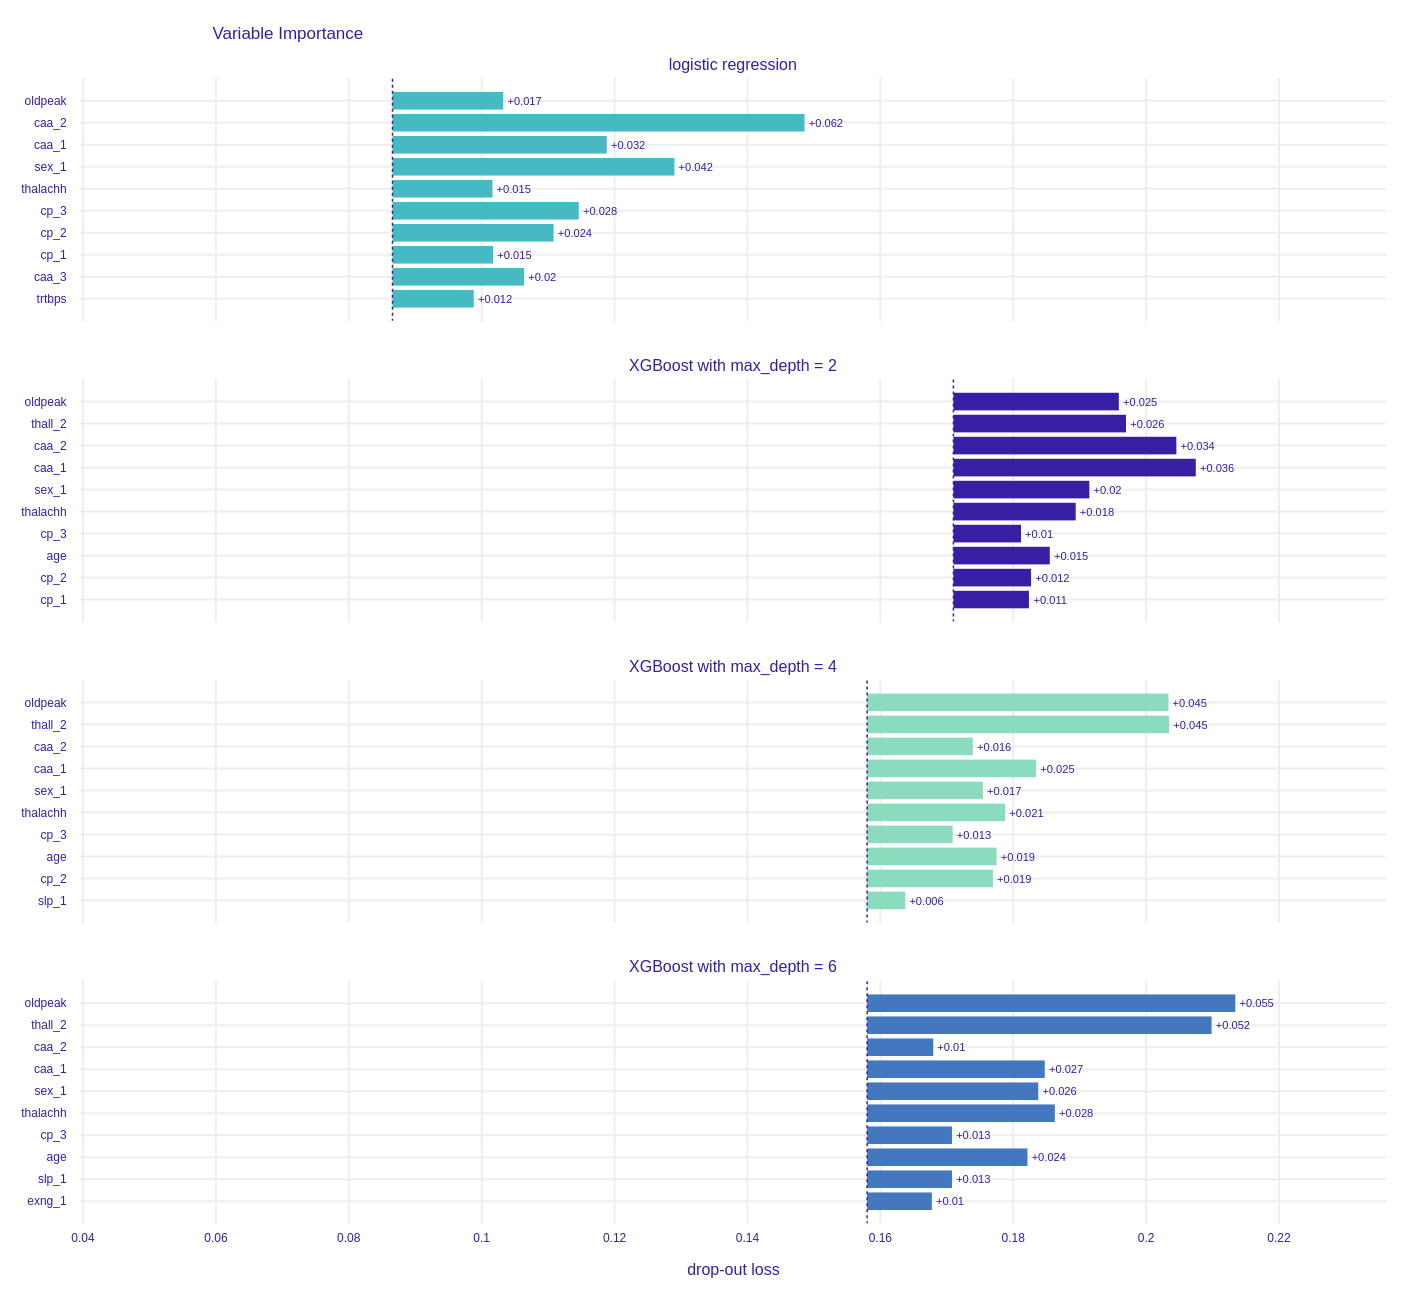

In [63]:
pvi_4.plot([pvi_3, pvi, pvi_2], show=False)

## 3. For the tree-based model from (1), compare PVI with:

###    A) the traditional feature importance measures for trees: Gini impurity etc.; what is implemented in a given library: see e.g. the feature_importances_ attribute in xgboost and sklearn.


In [34]:
importance_df = pd.DataFrame(data=dict(name=xgboost_model.feature_names_in_, importance=xgboost_model.feature_importances_))

In [51]:
xgboost_model.importance_type

'gain'

In [35]:
importance_df = importance_df.sort_values(by="importance", ascending=False)
importance_df = importance_df.head(10).iloc[::-1]

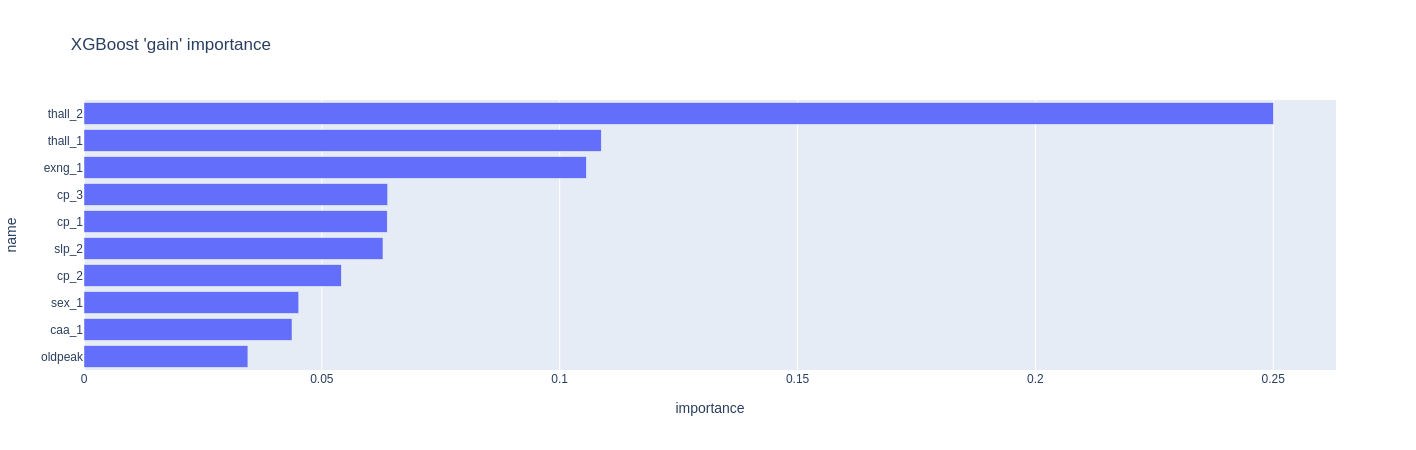

In [61]:
px.bar(data_frame=importance_df, x="importance", y="name", title="XGBoost 'gain' importance").update_layout(autosize=False, width=600, height=450)

###    B) [in Python] SHAP variable importance based on the TreeSHAP algorithm available in the shap package.


In [37]:
shap_explainer = shap.explainers.Tree(xgboost_model, data=X_train, model_output="probability")

In [38]:
shap_values = shap_explainer(X_test)

In [39]:
shap_values.values.shape

(61, 22)

In [40]:
vals = shap_values.values

In [41]:
shap_importances = np.abs(vals).mean(axis=0)

In [42]:
shap_importances.shape

(22,)

In [43]:
shap_df = pd.DataFrame(data=dict(name=xgboost_model.feature_names_in_, importance=shap_importances))

In [44]:
shap_df = shap_df.sort_values(by="importance", ascending=False)
shap_df = shap_df.head(10).iloc[::-1]

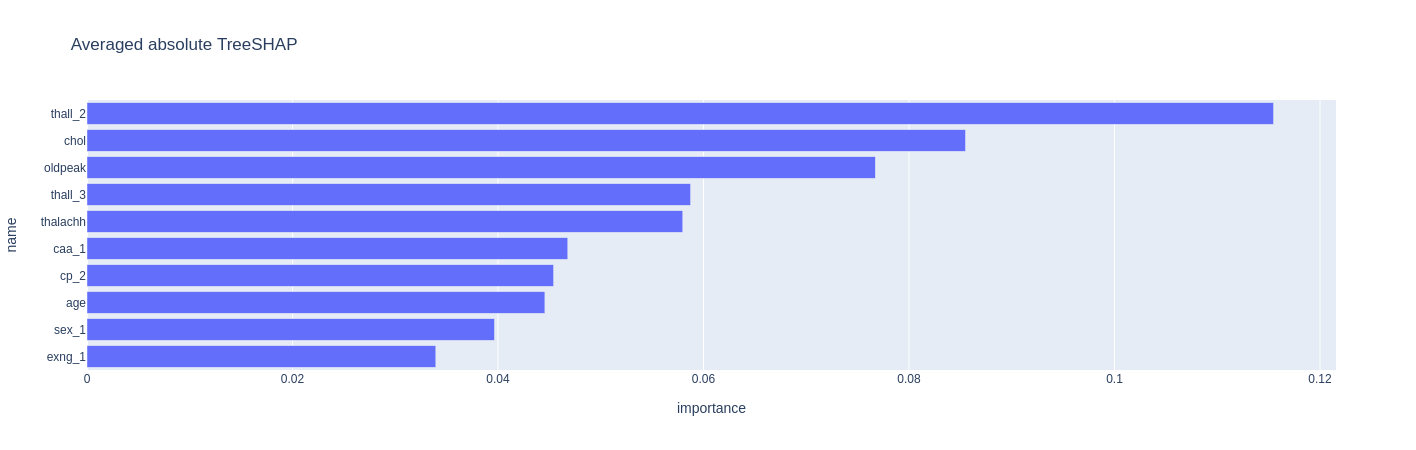

In [55]:
px.bar(data_frame=shap_df, x="importance", y="name", title="Averaged absolute TreeSHAP").update_layout(autosize=False, width=600, height=450)